<a href="https://colab.research.google.com/github/glimmer-jm/Projects/blob/main/Lung_Cancer_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define constants
IMG_SIZE = 128  # Image size for processing
BATCH_SIZE = 16  # Start with a smaller batch size to avoid memory issues
EPOCHS = 20
NUM_CLASSES = 3  # Focusing on lung classes only: normal, adenocarcinoma, squamous cell carcinoma

# Define paths - adjust these based on your actual file structure
LUNG_PATH = '/content/drive/MyDrive/lung_image_sets'
LUNG_CLASSES = ['lung_n', 'lung_aca', 'lung_scc']

In [ ]:
# Check if GPU is available and configure memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using {len(gpus)} GPU(s) with memory growth enabled")
    except RuntimeError as e:
        print(f"GPU memory configuration error: {e}")

In [ ]:
# Function to load and preprocess images with better error handling and progress tracking
def load_and_preprocess_data(base_path, classes, img_size, max_per_class=None):
    """
    Load and preprocess image data from the specified path

    Args:
        base_path (str): Base directory containing class folders
        classes (list): List of class folder names
        img_size (int): Size to resize images to
        max_per_class (int, optional): Maximum number of images to load per class

    Returns:
        tuple: (images array, labels array)
    """
    images = []
    labels = []

    # Track how many images loaded per class
    counts = {cls: 0 for cls in classes}

    for idx, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        print(f"Loading {class_name} from {class_path}")

        # Verify directory exists
        if not os.path.isdir(class_path):
            print(f"WARNING: Directory not found: {class_path}")
            continue

        # Get list of files
        try:
            files = os.listdir(class_path)
            print(f"Found {len(files)} files in {class_name}")
        except Exception as e:
            print(f"Error accessing directory {class_path}: {e}")
            continue

        # Limit number of files if specified
        if max_per_class:
            files = files[:max_per_class]

        # Process each file
        for i, file in enumerate(files):
            if i % 500 == 0:
                print(f"Processing {class_name}: {i}/{len(files)}")

            try:
                img_path = os.path.join(class_path, file)

                # Skip if not a jpeg file
                if not file.lower().endswith(('.jpeg', '.jpg')):
                    continue

                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue

                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize image
                img = cv2.resize(img, (img_size, img_size))

                # Normalize pixel values to [0,1]
                img = img / 255.0

                images.append(img)
                labels.append(idx)
                counts[class_name] += 1

            except Exception as e:
                print(f"Error processing {file}: {e}")

        print(f"Completed loading {class_name}: {counts[class_name]} images")

        # Clear memory periodically
        if len(images) % 5000 == 0:
            gc.collect()

    # Verify we have data
    if len(images) == 0:
        raise ValueError("No images were loaded. Check paths and file formats.")

    # Print class distribution
    print("\nClass distribution:")
    for cls in classes:
        print(f"{cls}: {counts[cls]} images")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Free up memory
    del images, labels
    gc.collect()

    return X, y

In [ ]:
# Function to create the model
def create_model(input_shape, num_classes):
    """
    Create a CNN model for image classification

    Args:
        input_shape (tuple): Shape of input images
        num_classes (int): Number of classes

    Returns:
        keras.Model: Compiled model
    """
    # Initialize model
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Function to train the model
def train_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs):
    """
    Train the model with appropriate callbacks and data augmentation

    Args:
        model (keras.Model): Model to train
        X_train, Y_train: Training data
        X_val, Y_val: Validation data
        batch_size (int): Batch size
        epochs (int): Maximum number of epochs

    Returns:
        history: Training history
    """
    # Create data augmentation for training images
    data_augmentation = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    # Setup callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            patience=5,
            restore_best_weights=True
        ),

        # Reduce learning rate when training plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=3,
            factor=0.5,
            min_lr=1e-6
        ),

        # Save best model
        ModelCheckpoint(
            'best_lung_cancer_model.h5',
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            save_best_only=True
        )
    ]

    # Train model with data augmentation
    try:
        print("\nStarting model training...")
        # Calculate steps per epoch to process all training data
        steps_per_epoch = len(X_train) // batch_size

        history = model.fit(
            data_augmentation.flow(X_train, Y_train, batch_size=batch_size),
            validation_data=(X_val, Y_val),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            verbose=1,
            callbacks=callbacks
        )

        print("\nTraining completed successfully!")
        return history

    except Exception as e:
        print(f"\nERROR during training: {e}")

        # Try to diagnose common issues
        if "resource exhausted" in str(e).lower() or "out of memory" in str(e).lower():
            print("\nMemory issue detected. Suggestions:")
            print("1. Reduce batch size (try BATCH_SIZE = 8 or 4)")
            print("2. Reduce image size (try IMG_SIZE = 96 or 64)")
            print("3. Load fewer images per class for testing (use max_per_class parameter)")
            print("4. Use a simpler model architecture")

        return None

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_val, Y_val, class_names):
    """
    Evaluate model performance and create visualizations

    Args:
        model (keras.Model): Trained model
        X_val, Y_val: Validation data
        class_names (list): Names of classes
    """
    print("\nEvaluating model on validation data...")

    # Get model predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(Y_val, axis=1)

    # Calculate and print metrics
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot sample incorrect predictions
    incorrect_indices = np.where(y_pred_classes != y_true_classes)[0]

    if len(incorrect_indices) > 0:
        plt.figure(figsize=(20, 10))
        num_to_show = min(10, len(incorrect_indices))

        for i, idx in enumerate(incorrect_indices[:num_to_show]):
            plt.subplot(2, 5, i + 1)
            plt.imshow(X_val[idx])
            true_class = class_names[y_true_classes[idx]]
            pred_class = class_names[y_pred_classes[idx]]
            plt.title(f"True: {true_class}\nPred: {pred_class}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics

    Args:
        history: Training history from model.fit()
    """
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(16, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# Main execution
def main():
    print("==== Lung Cancer Detection System ====")

    try:
        # Step 1: Load and preprocess data
        print("\nStep 1: Loading and preprocessing data...")
        # You can limit images per class during development with max_per_class parameter
        # For full training, remove max_per_class or set to None
        X, y = load_and_preprocess_data(LUNG_PATH, LUNG_CLASSES, IMG_SIZE, max_per_class=1000)
        print(f"Data loaded: X shape: {X.shape}, y shape: {y.shape}")

        # Step 2: Convert labels to one-hot encoding and split data
        print("\nStep 2: Preparing training and validation sets...")
        y_one_hot = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, y_one_hot, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Training data: {X_train.shape}, {Y_train.shape}")
        print(f"Validation data: {X_val.shape}, {Y_val.shape}")

        # Free memory
        del X, y, y_one_hot
        gc.collect()

        # Step 3: Create and compile model
        print("\nStep 3: Creating model...")
        model = create_model((IMG_SIZE, IMG_SIZE, 3), NUM_CLASSES)
        model.summary()

        # Step 4: Train model
        print("\nStep 4: Training model...")
        history = train_model(model, X_train, Y_train, X_val, Y_val, BATCH_SIZE, EPOCHS)

        if history is not None:
            # Step 5: Plot training history
            print("\nStep 5: Plotting training history...")
            plot_training_history(history)

            # Step 6: Evaluate model
            print("\nStep 6: Evaluating model...")
            evaluate_model(model, X_val, Y_val, LUNG_CLASSES)

            # Step 7: Save final model
            print("\nStep 7: Saving model...")
            model.save('final_lung_cancer_model.h5')
            print("Model saved as 'final_lung_cancer_model.h5'")

        print("\nProcess completed!")

    except Exception as e:
        print(f"\nERROR in main execution: {e}")
        import traceback
        traceback.print_exc()

==== Lung Cancer Detection System ====

Step 1: Loading and preprocessing data...
Loading lung_n from /content/drive/MyDrive/lung_image_sets/lung_n
Found 5000 files in lung_n
Processing lung_n: 0/1000
Processing lung_n: 500/1000
Completed loading lung_n: 1000 images
Loading lung_aca from /content/drive/MyDrive/lung_image_sets/lung_aca
Found 5000 files in lung_aca
Processing lung_aca: 0/1000
Processing lung_aca: 500/1000
Completed loading lung_aca: 1000 images
Loading lung_scc from /content/drive/MyDrive/lung_image_sets/lung_scc
Found 5000 files in lung_scc
Processing lung_scc: 0/1000
Processing lung_scc: 500/1000
Completed loading lung_scc: 1000 images

Class distribution:
lung_n: 1000 images
lung_aca: 1000 images
lung_scc: 1000 images
Data loaded: X shape: (3000, 128, 128, 3), y shape: (3000,)

Step 2: Preparing training and validation sets...
Training data: (2400, 128, 128, 3), (2400, 3)
Validation data: (600, 128, 128, 3), (600, 3)

Step 3: Creating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,712,483 (33.24 MB)

 Trainable params: 8,710,819 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)


Step 4: Training model...

Starting model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7776 - loss: 0.6240
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_lung_cancer_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.7778 - loss: 0.6234 - val_accuracy: 0.3333 - val_loss: 7.8797 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8152 - loss: 0.5117
Epoch 2: val_accuracy did not improve from 0.33333
150/150 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.8153 - loss: 0.5113 - val_accuracy: 0.3333 - val_loss: 4.5412 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8472 - loss: 0.4100
Epoch 3: val_accuracy improved from 0.33333 to 0.68333, saving model to best_lung_cancer_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.8472 - loss: 0.4100 - val_accuracy: 0.6833 - val_loss: 0.7919 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8676 - loss: 0.3426
Epoch 4: val_accuracy did not improve from 0.68333
150/150 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.8676 - loss: 0.3426 - val_accuracy: 0.6767 - val_loss: 1.5066 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8766 - loss: 0.3600
Epoch 5: val_accuracy improved from 0.68333 to 0.90667, saving model to best_lung_cancer_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.8766 - loss: 0.3598 - val_accuracy: 0.9067 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8919 - loss: 0.3010
Epoch 6: val_accuracy improved from 0.90667 to 0.93333, saving model to best_lung_cancer_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8919 - loss: 0.3010 - val_accuracy: 0.9333 - val_loss: 0.1610 - learning_rate: 0.0010
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8977 - loss: 0.2583
Epoch 7: val_accuracy did not improve from 0.93333
150/150 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.8977 - loss: 0.2583 - val_accuracy: 0.7533 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9131 - loss: 0.2382
Epoch 8: val_accuracy did not improve from 0.93333
150/150 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9131 - loss: 0.2382 - val_accuracy: 0.8183 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9010 - loss: 0.2685
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_accuracy did not improve from 0.93333
150/150 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.9009 - loss: 0.2685 - val_accurac

150/150 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.9157 - loss: 0.2223 - val_accuracy: 0.9517 - val_loss: 0.1348 - learning_rate: 5.0000e-04
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9267 - loss: 0.1907
Epoch 11: val_accuracy did not improve from 0.95167
150/150 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.9267 - loss: 0.1908 - val_accuracy: 0.9167 - val_loss: 0.1973 - learning_rate: 5.0000e-04
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9355 - loss: 0.1944
Epoch 12: val_accuracy did not improve from 0.95167
150/150 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.9355 - loss: 0.1944 - val_accuracy: 0.9200 - val_loss: 0.1952 - learning_rate: 5.0000e-04
Epoch 13/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9266 - loss: 0.2014
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: val_accuracy did not improve from 0.95167
150/150 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.9265 - loss: 0

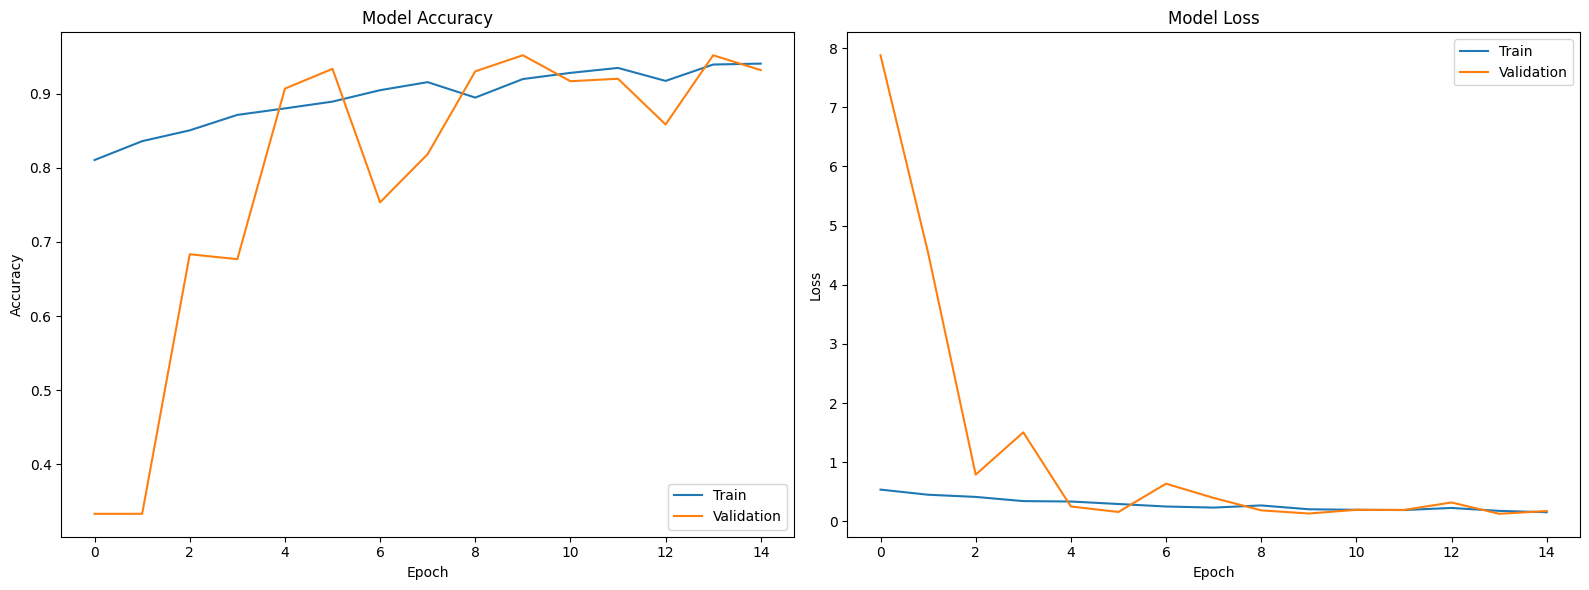


Step 6: Evaluating model...

Evaluating model on validation data...
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step

Classification Report:
              precision    recall  f1-score   support

      lung_n       1.00      1.00      1.00       200
    lung_aca       0.92      0.94      0.93       200
    lung_scc       0.93      0.92      0.93       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



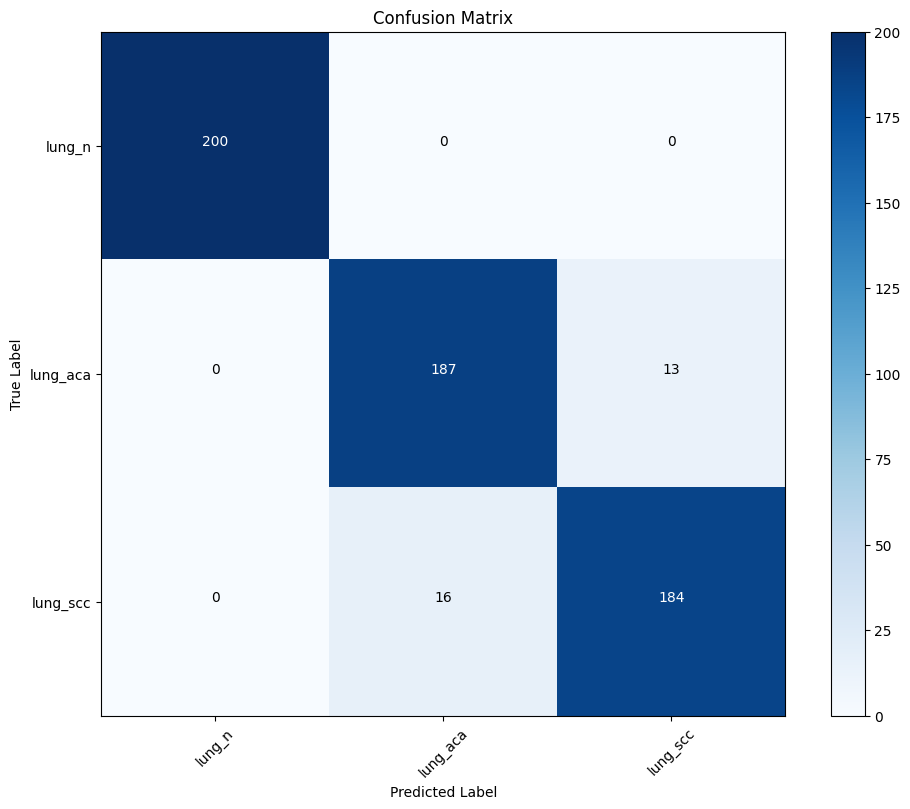

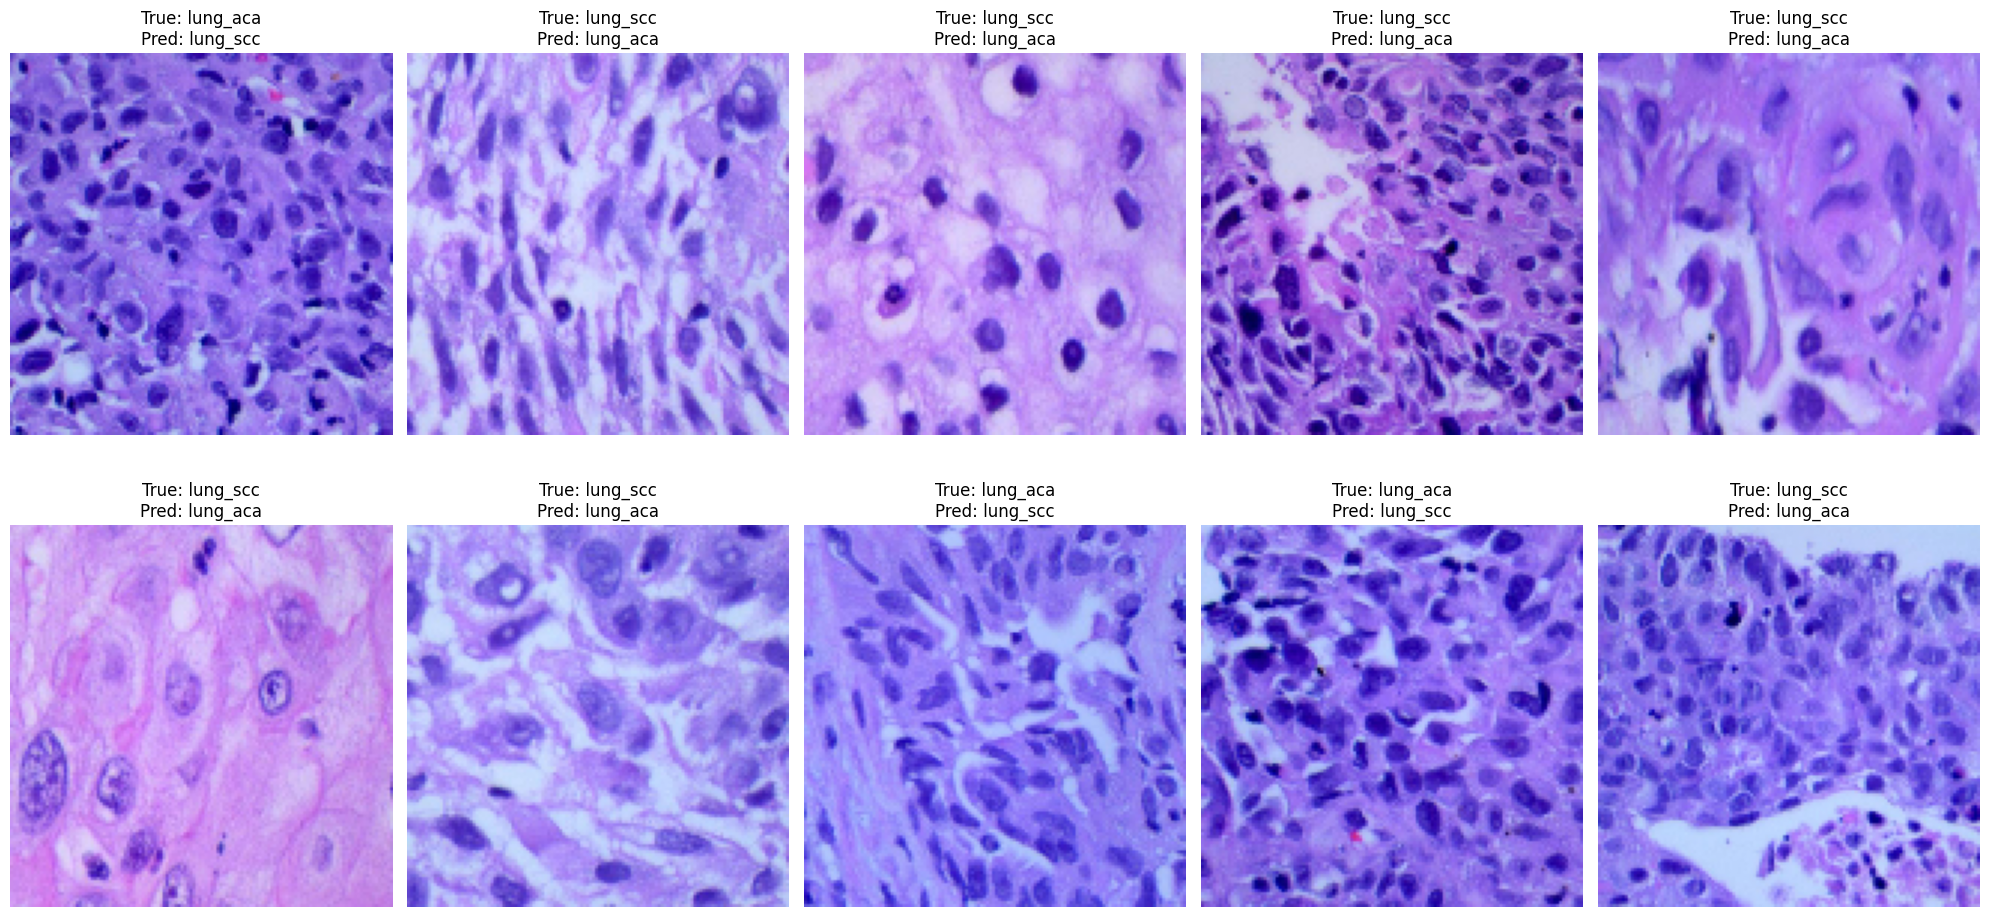


Step 7: Saving model...
Model saved as 'final_lung_cancer_model.h5'

Process completed!


In [ ]:
# Execute main function if running as script
if __name__ == "__main__":
    main()

In [ ]:
# Load the trained model
model = load_model('final_lung_cancer_model.h5')  # Replace with your model file

# Define image path
image_path = '/content/drive/MyDrive/lung_image_sets/lung_scc/lungscc1001.jpeg' #@param {type:"string"}

# Function to preprocess a single image
def preprocess_image(image_path, img_size=128):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image at {image_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        return np.expand_dims(img, axis=0)
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None


# Preprocess the image
preprocessed_image = preprocess_image(image_path)

if preprocessed_image is not None:
    # Make prediction
    prediction = model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction)

    # Define class labels
    class_labels = ['lung_n', 'lung_aca', 'lung_scc']

    # Print the prediction
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Prediction probabilities: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: lung_scc
Prediction probabilities: [[2.5713377e-04 5.9607001e-03 9.9378222e-01]]
